In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima # autoarima

from sklearn.metrics import mean_squared_error

import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit

# AutoARIMA with Exogen Variable

In [6]:
# import ecommerce_forecasting_data
df = pd.read_csv('ecommerce_forecasting_data.csv')
df

,date,sales,ad_budget,discount
0,2018-01,310,19,19.64
1,2018-02,305,22,8.12
2,2018-03,379,25,5.41
3,2018-04,344,19,8.67
4,2018-05,356,12,13.64
5,2018-06,351,15,7.79
6,2018-07,294,16,14.12
7,2018-08,276,26,15.28
8,2018-09,262,25,17.15
9,2018-10,256,29,6.95


## EDA

In [8]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name = 'true',x=df.index, y=df['sales'])])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

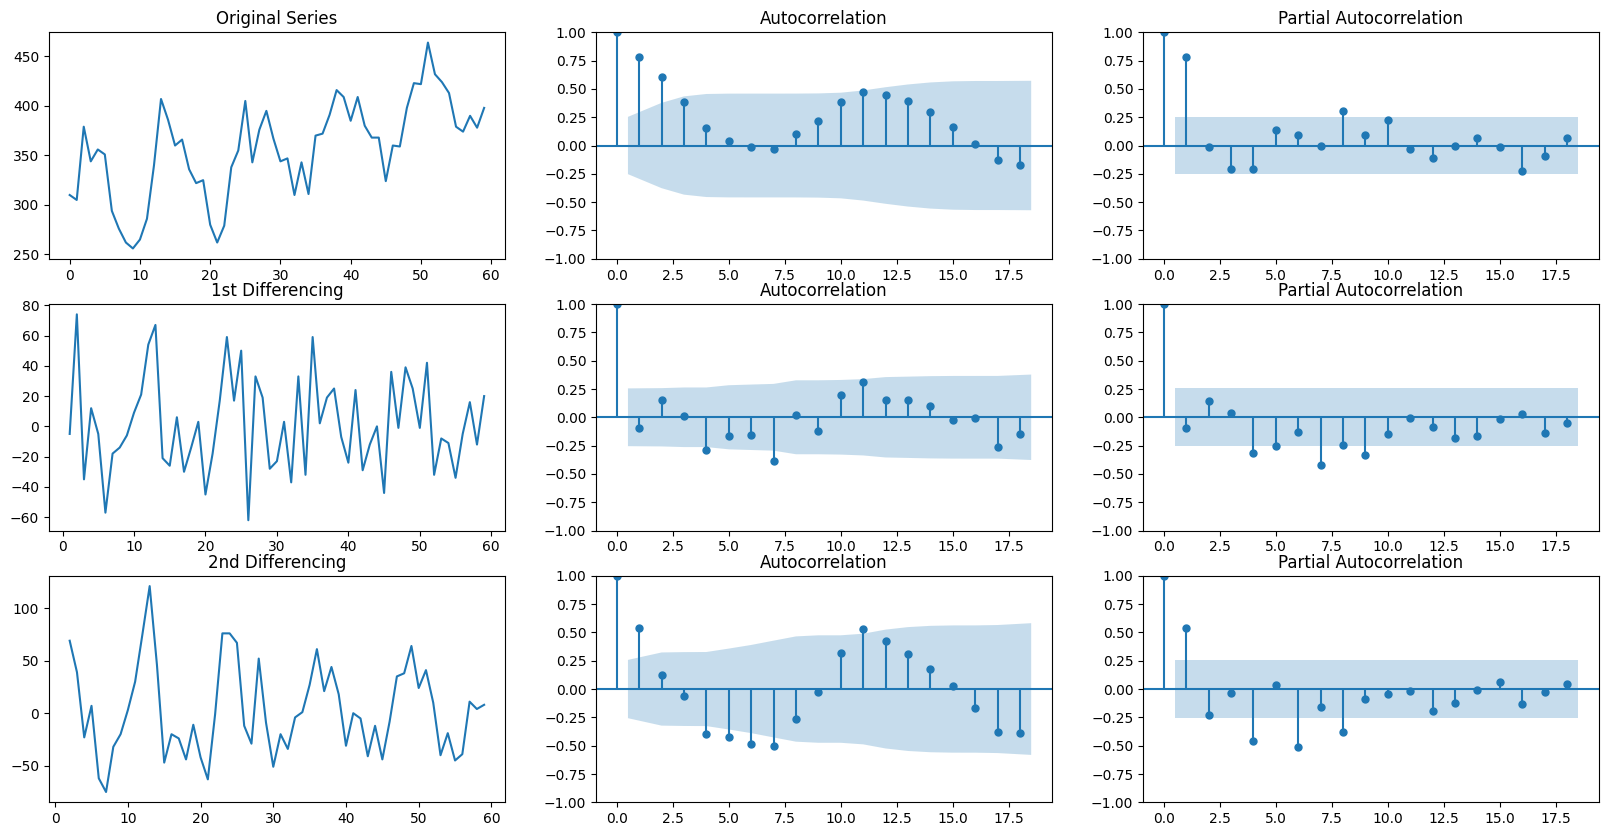

In [9]:
def acf_pacf(data, fitur):# Original
    fig, axes = plt.subplots(3,3, figsize = (20,10))
    axes[0, 0].plot(data[fitur]); axes[0, 0].set_title('Original Series')
    plot_acf(data[fitur], ax=axes[0, 1])
    plot_pacf(data[fitur], ax=axes[0, 2])

    # 1st Differencing
    axes[1, 0].plot(data[fitur].diff(1)); axes[1, 0].set_title('1st Differencing')
    plot_acf(data[fitur].diff(1).dropna(), ax=axes[1, 1])
    plot_pacf(data[fitur].diff(1).dropna(), ax=axes[1, 2])


    # 2nd Differencing
    axes[2, 0].plot(data[fitur].diff(2)); axes[2, 0].set_title('2nd Differencing')
    plot_acf(data[fitur].diff(2).dropna(), ax=axes[2, 1])
    plot_pacf(data[fitur].diff(2).dropna(), ax=axes[2, 2])

    plt.show()

acf_pacf(df, 'sales')

Kemungkinan ada seasonal per 10 baris

## Data Splitting

In [10]:
train = df.iloc[:-6]  # Semua data kecuali 6 data terakhir
test = df.iloc[-6:]   # 6 data terakhir untuk testing

In [11]:
train

,date,sales,ad_budget,discount
0,2018-01,310,19,19.64
1,2018-02,305,22,8.12
2,2018-03,379,25,5.41
3,2018-04,344,19,8.67
4,2018-05,356,12,13.64
5,2018-06,351,15,7.79
6,2018-07,294,16,14.12
7,2018-08,276,26,15.28
8,2018-09,262,25,17.15
9,2018-10,256,29,6.95


In [12]:
# Pisahkan variabel endogen (target) dan eksogen
y_train = train["sales"]
y_test = test["sales"]
X_train = train[["ad_budget", "discount"]]
X_test = test[["ad_budget", "discount"]]

## Modelling

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = auto_arima(
    y = y_train,
    X = X_train, # exogen
    seasonal = True, # seasonal disetting true
    m = 12, # musiman per 12 bulan atau per tahun
    stepwise = True,# random search, kalau False akan grid search
    trace = True, # agar keluar hasil setiap step prosesnya
    suppress_warnings = True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=566.608, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=529.082, Time=0.99 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=628.670, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=530.191, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=529.896, Time=1.85 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=527.351, Time=0.64 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=529.780, Time=0.51 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=527.361, Time=1.51 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=531.704, Time=1.19 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=537.954, Time=0.64 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, T

## Evaluasi

In [14]:
forecast = model.predict(n_periods = 6, X = X_test)
forecast

,0
54,401.545027
55,368.910314
56,358.691121
57,333.087711
58,352.938336
59,378.109154


In [15]:
# Visualisasi hasil prediksi dibandingkan data asli
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['sales'], mode='lines', name='Actual'))  # Data asli
fig.add_trace(go.Scatter(x=test.index, y=forecast, mode='lines', name='Forecast'))  # Hasil prediksi untuk test set
fig.update_layout(title='ARIMA Forecast vs Actual (Testing Data)', xaxis_title='Time', yaxis_title='Sales')
fig.show()

# Hitung RMSE antara hasil prediksi dan data testing
mse = mean_squared_error(y_test, forecast)
print(f"RMSE dari model pada 10 data terakhir adalah {mse ** 0.5}")

RMSE dari model pada 10 data terakhir adalah 28.07763445359421


# Model Regresi (selain ARIMA)

In [16]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Contoh data dengan musiman
np.random.seed(42)
n_obs = 120  # 10 tahun (12 bulan per tahun)

# Membuat data tanggal
start_date = datetime(2010, 1, 1)
dates = [start_date + timedelta(days=30 * i) for i in range(n_obs)]

# Data time series utama (penjualan - endogen) dengan musiman
seasonality = 20 * np.sin(2 * np.pi * np.arange(n_obs) / 12)  # Pola musiman
trend = np.linspace(200, 300, n_obs)  # Tren naik
random_noise = np.random.normal(loc=0, scale=10, size=n_obs)  # Noise acak
sales = trend + seasonality + random_noise

# Variabel eksogen 1 (anggaran iklan)
ad_budget = np.linspace(50, 100, n_obs) + np.random.normal(loc=0, scale=5, size=n_obs)

# Variabel eksogen 2 (diskon produk)
discount = np.random.normal(loc=10, scale=2, size=n_obs)

# Gabungkan semua data menjadi DataFrame
df = pd.DataFrame({
    "date": dates,
    "sales": sales,
    "ad_budget": ad_budget,
    "discount": discount
})

# Tampilkan hasil
df

,date,sales,ad_budget,discount
0,2010-01-01,204.967142,53.955160,8.414959
1,2010-01-31,209.457693,45.873231,9.770527
2,2010-03-02,225.478066,57.854308,11.009975
3,2010-04-01,237.751307,44.251249,11.731510
4,2010-05-01,218.340319,54.614958,7.599407
...,...,...,...,...
115,2019-06-13,289.654129,101.488923,7.994941
116,2019-07-13,279.811366,88.613783,9.962974
117,2019-08-12,266.632547,100.091935,9.422683
118,2019-09-11,293.267384,96.270900,10.645437


## Data Preparation

In [17]:
WINDOW_SIZE = 12

# Make a copy of the Bitcoin historical data with block reward feature
df_windowed = df.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_windowed[f"sales-{i+1}"] = df_windowed["sales"].shift(periods=i+1)
df_windowed.head(20)

,date,sales,ad_budget,discount,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,2010-01-01,204.967142,53.955160,8.414959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-31,209.457693,45.873231,9.770527,204.967142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-03-02,225.478066,57.854308,11.009975,209.457693,204.967142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-04-01,237.751307,44.251249,11.731510,225.478066,209.457693,204.967142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-05-01,218.340319,54.614958,7.599407,237.751307,225.478066,209.457693,204.967142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-05-31,211.860311,63.053118,9.330998,218.340319,237.751307,225.478066,209.457693,204.967142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2010-06-30,220.834145,47.568327,9.050109,211.860311,218.340319,237.751307,225.478066,209.457693,204.967142,NaN,NaN,NaN,NaN,NaN,NaN
7,2010-07-30,203.556700,50.109688,8.693342,220.834145,211.860311,218.340319,237.751307,225.478066,209.457693,204.967142,NaN,NaN,NaN,NaN,NaN
8,2010-08-29,184.707437,53.859601,13.530908,203.556700,220.834145,211.860311,218.340319,237.751307,225.478066,209.457693,204.967142,NaN,NaN,NaN,NaN
9,2010-09-28,192.988626,51.264134,10.809963,184.707437,203.556700,220.834145,211.860311,218.340319,237.751307,225.478066,209.457693,204.967142,NaN,NaN,NaN


In [18]:
# hapus NaN
df_windowed = df_windowed.dropna()
df_windowed

,date,sales,ad_budget,discount,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
12,2010-12-27,212.503656,49.730498,14.244312,194.586400,186.448676,192.988626,184.707437,203.556700,220.834145,211.860311,218.340319,237.751307,225.478066,209.457693,204.967142
13,2011-01-26,201.791567,57.830147,12.064931,212.503656,194.586400,186.448676,192.988626,184.707437,203.556700,220.834145,211.860311,218.340319,237.751307,225.478066,209.457693
14,2011-02-25,211.836036,51.285232,6.961260,201.791567,212.503656,194.586400,186.448676,192.988626,184.707437,203.556700,220.834145,211.860311,218.340319,237.751307,225.478066
15,2011-03-27,226.982167,64.052193,9.031532,211.836036,201.791567,212.503656,194.586400,186.448676,192.988626,184.707437,203.556700,220.834145,211.860311,218.340319,237.751307
16,2011-04-26,220.637575,52.806423,12.533822,226.982167,211.836036,201.791567,212.503656,194.586400,186.448676,192.988626,184.707437,203.556700,220.834145,211.860311,218.340319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2019-06-13,289.654129,101.488923,7.994941,293.874710,329.590404,312.040457,313.012172,290.569771,300.852179,293.331806,281.661745,290.616981,272.275803,268.461593,268.531849
116,2019-07-13,279.811366,88.613783,9.962974,289.654129,293.874710,329.590404,312.040457,313.012172,290.569771,300.852179,293.331806,281.661745,290.616981,272.275803,268.461593
117,2019-08-12,266.632547,100.091935,9.422683,279.811366,289.654129,293.874710,329.590404,312.040457,313.012172,290.569771,300.852179,293.331806,281.661745,290.616981,272.275803
118,2019-09-11,293.267384,96.270900,10.645437,266.632547,279.811366,289.654129,293.874710,329.590404,312.040457,313.012172,290.569771,300.852179,293.331806,281.661745,290.616981


## Data Splitting

In [19]:
X = df_windowed.drop(columns = ['date', 'sales'])
y = df_windowed['sales']

# Split data: test size hanya 1 baris terakhir
X_train, X_test = X[:-5], X[-5:]  # Semua kecuali terakhir untuk training, terakhir untuk testing
y_train, y_test = y[:-5], y[-5:]  # Sama untuk target

In [20]:
# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (103, 14)
y_train shape: (103,)
X_test shape: (5, 14)
y_test shape: (5,)


## Modelling

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Inisialisasi model XGBoost Regressor
model = xgb.XGBRegressor()

# Inisialisasi list untuk menyimpan prediksi
predictions = []

# Loop melalui setiap baris di X_test
for i in range(len(X_test)):
    # Latih model dengan data X_train dan y_train
    model.fit(X_train, y_train)

    # Prediksi nilai untuk baris pertama di X_test
    y_pred = model.predict(X_test.iloc[[i]])
    predictions.append(y_pred[0])

    # Tambahkan baris pertama X_test dan y_pred ke X_train dan y_train
    X_train = pd.concat([X_train, X_test.iloc[[i]]])
    y_train = pd.concat([y_train, pd.Series(y_pred[0], index=[X_test.index[i]])])

# Evaluasi model
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print(f"RMSE: {rmse}")

RMSE: 13.821972655024


In [22]:
print(predictions)
print(y_test)

[294.45972, 293.69763, 291.26376, 302.9871, 291.34332]
115    289.654129
116    279.811366
117    266.632547
118    293.267384
119    297.519330
Name: sales, dtype: float64


## Evaluasi

In [23]:
# Visualisasi hasil prediksi dibandingkan data asli
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_windowed.index, y=df_windowed['sales'], mode='lines', name='Actual'))  # Data asli
fig.add_trace(go.Scatter(x=X_test.index, y=predictions, mode='lines', name='Forecast'))  # Hasil prediksi untuk test set
fig.update_layout(title='ARIMA Forecast vs Actual (Testing Data)', xaxis_title='Time', yaxis_title='Sales')
fig.show()

# Hitung RMSE antara hasil prediksi dan data testing
mse = mean_squared_error(y_test, predictions)
print(f"RMSE dari model pada 10 data terakhir adalah {mse ** 0.5}")

RMSE dari model pada 10 data terakhir adalah 13.821972655024


# Time Series Cross Validation

## ARIMA

In [24]:


# Define the number of splits for cross-validation
n_splits = 5

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lists to store evaluation metrics for each fold
rmse_scores = []

# Iterate through the folds
for fold, (train_index, test_index) in enumerate(tscv.split(df), start=1):
    # Split data into train and test
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = df["sales"].iloc[train_index], df["sales"].iloc[test_index]

    # Separate exogenous variables
    X_train_exog = X_train[["ad_budget", "discount"]]
    X_test_exog = X_test[["ad_budget", "discount"]]

    # Train the model using auto_arima
    model = auto_arima(
        y=y_train,
        X=X_train_exog,
        seasonal=True,
        m=12,
        stepwise=True,
        trace=False,
        suppress_warnings=True,
    )

    # Generate forecast for the test set
    forecast = model.predict(n_periods=len(X_test_exog), X=X_test_exog)
    mse = mean_squared_error(y_test, forecast)
    rmse = mse ** 0.5
    rmse_scores.append(rmse)
    print(f"Fold {fold} RMSE: {rmse}")

    # Combine train and test for visualization
    y_full = pd.concat([y_train, y_test])  # Full data (train + test)
    forecast_full = pd.Series(data=np.nan, index=y_full.index)  # Placeholder for predictions
    forecast_full.iloc[len(y_train):] = forecast  # Fill predictions for test set

    # Visualization for the current fold
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_full.index, y=y_full, mode='lines', name='Actual (Train + Test)'))  # Data aktual
    fig.add_trace(go.Scatter(x=y_full.index, y=forecast_full, mode='lines', name='Predicted (Test)'))  # Prediksi
    fig.update_layout(
        title=f'Forecast vs Actual (Fold {fold})',
        xaxis_title='Time',
        yaxis_title='Sales',
    )
    fig.show()

# Calculate the average RMSE across all folds
avg_rmse = np.mean(rmse_scores)
print(f"\nAverage RMSE across {n_splits} folds: {avg_rmse}")


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/utils.py:117: UserWarning:

Appropriate D value may not have been reached; length of seasonally-differenced array (8) is shorter than m (12). Using D=1



Fold 1 RMSE: 27.718642827281197


Fold 2 RMSE: 22.585216027954164


Fold 3 RMSE: 25.53124905481034


Fold 4 RMSE: 19.897514791347067


Fold 5 RMSE: 10.194207092728222



Average RMSE across 5 folds: 21.1853659588242


## Beberapa Model Regresi

### XGBoost

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go


def time_series_cross_validation_with_full_plot(df, target_column, exogenous_columns, window_size=12, n_splits=5, model_input=xgb.XGBRegressor()):
    # Data Preparation with Windowing
    df_windowed = df.copy()
    for i in range(window_size):
        df_windowed[f"{target_column}-{i+1}"] = df_windowed[target_column].shift(periods=i+1)
    df_windowed = df_windowed.dropna()

    X = df_windowed.drop(columns=['date', target_column])  # Assuming 'date' column exists
    y = df_windowed[target_column]

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(df_windowed), start=1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = model_input
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        mse = mean_squared_error(y_test, predictions)
        rmse = mse ** 0.5
        rmse_scores.append(rmse)
        print(f"Fold {fold} RMSE: {rmse}")

        # Combine train and test for visualization
        y_full = pd.concat([y_train, y_test])  # Full y (train + test)
        predictions_full = pd.Series(data=np.nan, index=y_full.index)  # Create a full-sized Series for predictions
        predictions_full.iloc[len(y_train):] = predictions  # Add test predictions

        # Visualization for each fold
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=y_full.index, y=y_full, mode='lines', name='Actual (Train + Test)'))  # Data asli (Train + Test)
        fig.add_trace(go.Scatter(x=y_full.index, y=predictions_full, mode='lines', name='Predicted (Test)'))  # Prediksi hanya di Test
        fig.update_layout(
            title=f'Forecast vs Actual (Fold {fold})',
            xaxis_title='Time',
            yaxis_title=target_column,
        )
        fig.show()

    avg_rmse = np.mean(rmse_scores)
    print(f"\nAverage RMSE across {n_splits} folds: {avg_rmse}")
    return avg_rmse


# Example usage (replace with your actual DataFrame and column names)
# Assuming your data is in a dataframe called 'df'
avg_rmse = time_series_cross_validation_with_full_plot(df, 'sales', ['ad_budget', 'discount'], model_input=xgb.XGBRegressor())


Fold 1 RMSE: 14.482340809399505


Fold 2 RMSE: 18.926725250378258


Fold 3 RMSE: 14.223808403153114


Fold 4 RMSE: 17.49448299333294


Fold 5 RMSE: 17.143707122871785



Average RMSE across 5 folds: 16.45421291582712


### Linear Regression

In [26]:
# import linear regression
from sklearn.linear_model import LinearRegression

# prompt: terapkan linear regression dengan forecast timeseries crossvalidation

In [27]:
time_series_cross_validation_with_full_plot(df, 'sales', ['ad_budget', 'discount'], model_input = LinearRegression())

Fold 1 RMSE: 38.825592402927754


Fold 2 RMSE: 10.760465959486497


Fold 3 RMSE: 13.834297858210594


Fold 4 RMSE: 9.591679807547195


Fold 5 RMSE: 12.186632702611586



Average RMSE across 5 folds: 17.039733746156724


17.039733746156724

### Random Forest Regressor

In [28]:
# import
from sklearn.ensemble import RandomForestRegressor
time_series_cross_validation_with_full_plot(df, 'sales', ['ad_budget', 'discount'], model_input = RandomForestRegressor())

Fold 1 RMSE: 14.748975562835081


Fold 2 RMSE: 15.977987601785207


Fold 3 RMSE: 13.959762248567833


Fold 4 RMSE: 15.560502750083993


Fold 5 RMSE: 15.06043917066824



Average RMSE across 5 folds: 15.061533466788068


15.061533466788068

### SVM

In [29]:
# import
from sklearn.svm import SVR
time_series_cross_validation_with_full_plot(df, 'sales', ['ad_budget', 'discount'], model_input = SVR())

Fold 1 RMSE: 19.996133892666077


Fold 2 RMSE: 33.94904004683204


Fold 3 RMSE: 28.151173320993248


Fold 4 RMSE: 36.98780726006159


Fold 5 RMSE: 36.51418189845478



Average RMSE across 5 folds: 31.11966728380155


31.11966728380155